In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def cm2inch(value):
    return value/2.54

In [98]:
plotsize_subplots = (cm2inch(19),cm2inch(3.5))
#plotsize_subplots = (cm2inch(19),cm2inch(9))
#plotsize_subplots = (16,3)

fontsize_axis = 7
fontsize_labels = 7
fontsize_legends = 4

plt.rcParams.update({'figure.figsize': plotsize_subplots,
                     'axes.titlesize': fontsize_labels,
                     'axes.labelsize': fontsize_labels,
                     'ytick.labelsize': 'small'})

# Functions

In [4]:
def calculate_T_conn_and_memory(df):
    """Calculate T_conn and memory_per_rank"""
    df['T_bld_xn'] = df['T_conns_min'] + df['T_ini_max']
    df['T_bld_nx'] = df['T_conns_max'] + df['T_ini_min']
    df['Conn. Total']   = df[['T_bld_xn', 'T_bld_nx']].min(axis=1)
    df['Conn. Creation (min)'] = df['T_conns_min']
    df['Conn. Exchange (min)'] = df['T_ini_min']

    
    if 'NUM_VPS' not in list(df):
        df['N_VP'] = df['NUMBER_OF_NODES']*df['TASKS_PER_NODE']*df['THREADS_PER_TASK']
    else:
        df['N_VP'] = df['NUM_VPS']
    if np.isnan(df['VSize_sum']).all():
        df['VSize_sum'] = df['VSize_ini_sum']
    if 'VSize_mem_sum' not in list(df) and 'VSize_nodes_sum' not in list(df): #MAM
        df['VSize_mem_sum'] = df['VSize_net_sum']
        df['VSize_nodes_sum'] = [0]*len(df)
    
    # Er denne konverteringen riktig?
    # Vi har MiB = 1024**2 B
    # Verdien vi får fra NEST er i KiB (http://www.nest-simulator.org/helpindex/sli/memory_thisjob.html)
    
    df['connections'] = ((df['VSize_mem_sum']-df['VSize_nodes_sum'])/df['N_VP'])*1024/1024**3
    df['ini'] = ((df['VSize_ini_sum']-df['VSize_mem_sum'])/df['N_VP'])*1024/1024**3
    df['other'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3 - df['connections'] - df['ini']
    df['Memory per Rank'] = (df['VSize_sum']/df['N_VP'])*1024/1024**3
    
    if False:
        print(df['connections'])
        print(df['ini'])
        print(df['other'])
        print(df['connections'] + df['ini'] + df['other'])
        print(df['memory_per_rank'])

        print((df['connections'] + df['ini'] + df['other']) == df['memory_per_rank'])

    return df

In [48]:
def time_and_memory_per_connection(df):
    df = time_per_connection(df)
    df = memory_per_connection(df)
    return df

In [70]:
def time_per_connection(df):
    df['Total Conn. Time per Conn.'] = df['Conn. Total']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Creation Time per Conn. (min)'] = df['Conn. Creation (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    df['Conn. Exchange Time per Conn. (min)'] = df['Conn. Exchange (min)']/df['N_conns_sum'] * df['N_VP'] * 1e6
    return df

In [52]:
def memory_per_connection(df):
    df['Memory per connection'] = (df['VSize_ini_sum'] - df['VSize_nodes_sum']) / df['N_conns_sum']
    #(df['connections'] + df['ini']) * df['N_VP'] / df['N_conns_sum'] * 1024**2
    return df

In [89]:
def plot_results(df, name, plot_T_sim=False, index=None, legend_loc='lower right', rot=45):
    ncols = 4
    values = ['Conn. Exchange (min)', 'Conn. Creation (min)', 'Conn. Total']
    
    if not index:
        index='N_VP'
    
    if plot_T_sim:
        values += ['T_sim']
        ncols += 1
    
    df_p = pd.pivot_table(df, index=[index], values=values)
    df_mem = pd.pivot_table(df, index=[index], values=['connections', 'ini', 'other'])
    
    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=ncols)
    
    df_p.plot(kind='bar', capsize=4, subplots=True, legend=False, ax=axes[:ncols-1], fontsize=fontsize_axis,
              rot=rot, color=plt.rcParams['axes.prop_cycle'].by_key()['color'][0])
    df_mem.plot(kind='bar', capsize=4, stacked=True, legend=True, ax=axes[ncols-1],
                fontsize=fontsize_axis, rot=rot, color=['purple', 'pink', 'red'])
    
    plt.legend(labels=('Connections', 'Exchange', 'Other'), fontsize=6, loc=legend_loc)
    
    plt.subplots_adjust(wspace=0.4)
    
    # dashed line
    for i, val_name in enumerate(list(df_p)):
        axes[i].axhline(y=df[val_name][0], linestyle='--', color='grey')
        axes[i].set_xlabel(index)
    
    # y-axes labels
    axes[0].set_ylabel('Time [s]')
    
    # memory plot
    axes[ncols-1].axhline(y=df['Memory per Rank'][0], linestyle='--', color='grey')
    axes[ncols-1].set_ylabel('Memory [GiB]')
    axes[ncols-1].set_title('Memory per Rank')
    axes[ncols-1].set_xlabel(index)
    axes[ncols-1].ticklabel_format(style='sci', scilimits=(-3,2), axis='y', useMathText=False)
    axes[ncols-1].get_yaxis().get_offset_text().set_position((-0.2,0))
    
    fig.savefig(name, bbox_inches='tight')
    
    df_p['connections'] = df_mem['connections']
    df_p['ini'] = df_mem['ini']
    df_p['other'] = df_mem['other']
    return df_p

In [99]:
def plot_compare(df, name, values=None, index=None, legend_loc='lower right', rot=45, logy=False):
    """Plot times for different cases"""
    
    if not values:
        values=['Conn. Creation (min)', 'Conn. Exchange (min)', 'Conn. Total', 'Memory per Rank']
    if not index:
        index='N_VP'
    df_p = pd.pivot_table(df, index=index, columns='Case', values=values)


    # Make subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(values))
    #fig, axes = plt.subplots(nrows=2, ncols=2)

    for indx, val_name in enumerate(values):
        df_p[val_name].plot(kind='bar', ax = axes[indx], title=val_name, fontsize=fontsize_axis, rot=rot, logy=logy)
        axes[indx].legend(fontsize=fontsize_legends, loc=legend_loc)
    #df_p['Conn. Creation (min)'].plot(kind='bar', ax = axes[0][0], title='Conn. Creation (min)', fontsize=fontsize_axis, rot=rot)
    #axes[0][0].legend(fontsize=fontsize_legends, loc=legend_loc)
    #df_p['Conn. Exchange (min)'].plot(kind='bar', ax = axes[0][1], title='Conn. Exchange (min)', fontsize=fontsize_axis, rot=rot)
    #axes[0][1].legend(fontsize=fontsize_legends, loc=legend_loc)
    #df_p['Conn. Total'].plot(kind='bar', ax = axes[1][0], title='Conn. Total', fontsize=fontsize_axis, rot=rot)
    #axes[1][0].legend(fontsize=fontsize_legends, loc=legend_loc)
    #df_p['Memory per Rank'].plot(kind='bar', ax = axes[1][1], title='Memory per Rank', fontsize=fontsize_axis, rot=rot)
    #axes[1][1].legend(fontsize=fontsize_legends, loc=legend_loc)
        
    plt.subplots_adjust(wspace=0.5)#, hspace=0.7)

    # y-axis labels
    if 'Conn. Creation Time \n per Conn. (min)' in values:  
        axes[0].set_ylabel(r'Time [$\mu$s]')  # Not safe..
    else:
        axes[0].set_ylabel('Time [s]')
        #axes[0][0].set_ylabel('Time [s]')
        #axes[1][0].set_ylabel('Time [s]')
    if 'Memory per Rank' in values:
        # Assume memory is last entry in values
        axes[len(values) - 1].set_ylabel('Memory [GiB]')
        #axes[1][1].set_ylabel('Memory [GiB]')
    elif 'Memory per connection' in values:
        axes[len(values) - 1].set_ylabel('Memory [B]')

    # x-axis labels
    for ax in axes:
        ax.set_xlabel(index)

    fig = plt.gcf()
    fig.savefig(name, bbox_inches='tight')
    
    return df_p

In [90]:
def save_table_latex(text, name):
    f = open(name, "w")
    f.write(text)
    f.close()

# FIGURES

## HPC_benchmark

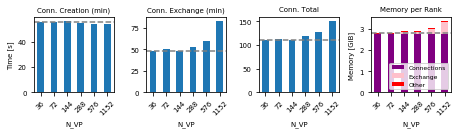

In [91]:
hpc_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20.csv')

hpc_t6_s20 = calculate_T_conn_and_memory(hpc_t6_s20)
hpc_t6_s20_p = plot_results(hpc_t6_s20, 'benchmark_figures/hpc_benchmark.pdf', plot_T_sim=False)

save_table_latex(hpc_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_table.txt')
# print(hpc_t6_s20['N_conns_sum'])
# print(hpc_t6_s20['N_nrns'])

## HPC static

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,50.38,44.34,106.29,1.930745,0.082848,0.057636
72,50.39,47.27,108.31,1.930745,0.140628,0.055966
144,50.61,46.64,110.56,1.930745,0.138309,0.053382
288,48.95,49.19,110.87,1.951579,0.350760,0.053393
576,49.90,59.29,121.61,1.993245,0.419607,0.053747
1152,49.24,81.91,144.39,1.993083,0.452431,0.054612


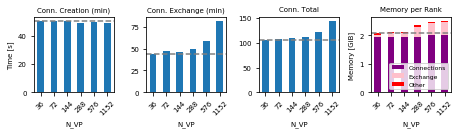

In [92]:
hpc_static_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_static.csv')

hpc_static_t6_s20 = calculate_T_conn_and_memory(hpc_static_t6_s20)
hpc_static_t6_s20_p = plot_results(hpc_static_t6_s20, 'benchmark_figures/hpc_benchmark_static.pdf')

save_table_latex(hpc_static_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_table.txt')
hpc_static_t6_s20_p

## HPC delay 0.1 - 50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,59.03,55.15,123.98,2.743245,0.022139,0.051125
72,59.38,62.68,130.93,2.743245,0.036027,0.053362
144,59.12,56.11,126.83,2.743245,0.113203,0.053382
288,57.37,59.52,130.55,2.743245,0.170184,0.053393
576,57.13,66.91,139.17,2.743245,0.520410,0.053747
1152,56.60,91.91,165.08,2.743083,0.604612,0.054612


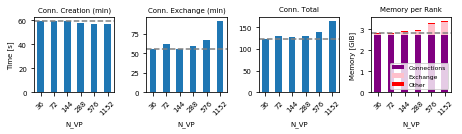

In [93]:
hpc_delay_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_random_delays.csv')

hpc_delay_t6_s20 = calculate_T_conn_and_memory(hpc_delay_t6_s20)
hpc_delay_t6_s20_p = plot_results(hpc_delay_t6_s20, 'benchmark_figures/hpc_benchmark_random_delays.pdf')

save_table_latex(hpc_delay_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_random_delays_table.txt')
hpc_delay_t6_s20_p

## HPC static, delay 0.1-50.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,52.94,48.75,108.34,1.930745,0.395348,0.051125
72,53.27,48.90,109.68,1.930745,0.394128,0.053362
144,54.14,52.98,117.80,1.930745,0.403486,0.053382
288,52.39,53.71,117.39,1.951579,0.457815,0.053393
576,52.51,62.07,127.60,1.993245,0.417980,0.053747
1152,52.16,91.93,156.84,1.993083,0.452973,0.054612


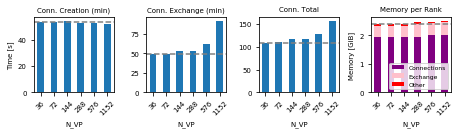

In [94]:
hpc_static_del_t6_s20 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_s20_static_random_delays.csv')

hpc_static_del_t6_s20 = calculate_T_conn_and_memory(hpc_static_del_t6_s20)
hpc_static_del_t6_s20_p = plot_results(hpc_static_del_t6_s20,
                                       'benchmark_figures/hpc_benchmark_static_random_delays.pdf')

save_table_latex(hpc_static_del_t6_s20_p.to_latex(), 'latex_tables/hpc_benchmark_static_random_delays_table.txt')
hpc_static_del_t6_s20_p

## Comparing different cases from above

Conn. Creation (min)                                                      \
Case              Default Random delay Random delay and static Static synapse   
N_VP                                                                            
36                  55.93        59.03                   52.94          50.38   
72                  56.16        59.38                   53.27          50.39   
144                 56.73        59.12                   54.14          50.61   
288                 55.07        57.37                   52.39          48.95   
576                 53.97        57.13                   52.51          49.90   
1152                53.90        56.60                   52.16          49.24   

     Conn. Exchange (min)                                                      \
Case              Default Random delay Random delay and static Static synapse   
N_VP                                                                            
36                  47.75        55.15                   48.75          44.34   
72                  50.03        62.68                   48.90          47.27   
144                 47.69        56.11                   52.98          46.64   
288                 52.39        59.52                   53.71          49.19   
576                 59.77        66.91                   62.07          59.29   
1152                83.27        91.91                   91.93          81.91   

     Conn. Total                                                      \
Case     Default Random delay Random delay and static Static synapse   
N_VP                                                                   
36        110.79       123.98                  108.34         106.29   
72        113.02       130.93                  109.68         108.31   
144       111.17       126.83                  117.80         110.56   
288       119.53       130.55                  117.39         110.87   
576       126.65       139.17                  127.60         121.61   
1152      150.91       165.08                  156.84         144.39   

     Memory per Rank                                                      
Case         Default Random delay Random delay and static Static synapse  
N_VP                                                                      
36          2.822043     2.816509                2.377219       2.071229  
72          2.821839     2.832635                2.378235       2.127340  
144         2.905517     2.909830                2.387614       2.122436  
288         2.910500     2.966822                2.462787       2.355732  
576         3.035068     3.317403                2.464972       2.466600  
1152        3.382232     3.402306                2.500667       2.500125

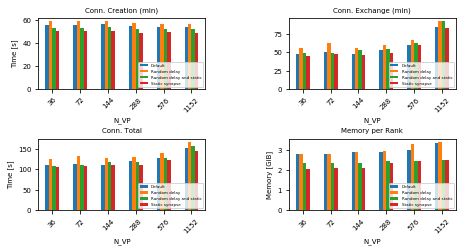

In [97]:
hpc_t6_s20['Case'] = ['Default'] * len(hpc_t6_s20)
hpc_static_t6_s20['Case'] = ['Static synapse'] * len(hpc_static_t6_s20)
hpc_delay_t6_s20['Case'] = ['Random delay'] * len(hpc_delay_t6_s20)
hpc_static_del_t6_s20['Case'] = ['Random delay and static'] * len(hpc_static_del_t6_s20)

hpc_cases = pd.concat([hpc_t6_s20, hpc_static_t6_s20, hpc_delay_t6_s20, hpc_static_del_t6_s20])

hpc_cases_p = plot_compare(hpc_cases, 'benchmark_figures/hpc_cases.pdf', legend_loc='lower right')
save_table_latex(hpc_cases_p.to_latex(), 'latex_tables/hpc_cases_table.txt')

hpc_cases_p

## Population model

0     2500000000
1     5000000000
2    10000000000
3    20000000000
4    40000000000
5    80000000000
Name: N_conns_sum, dtype: int64
0      500000
1     1000000
2     2000000
3     4000000
4     8000000
5    16000000
Name: N_nrns, dtype: int64


,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,45.75,39.25,93.81,1.979818,0.105624,0.065204
72,46.64,40.00,95.79,1.975260,0.123853,0.071347
144,47.91,40.45,98.53,1.975260,0.215827,0.071367
288,50.44,43.82,103.67,1.975260,0.116873,0.071378
576,54.71,54.46,118.66,1.975260,0.398448,0.071732
1152,66.78,95.90,176.92,1.975260,0.454258,0.072434


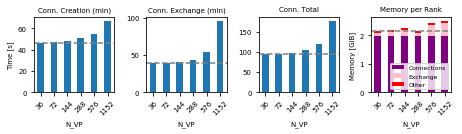

In [100]:
population = pd.read_csv('benchmark_results/population_model_8adec3cd_daint_t6.csv')

population = calculate_T_conn_and_memory(population)
population_p = plot_results(population, 'benchmark_figures/population_model.pdf', plot_T_sim=False)

save_table_latex(population_p.to_latex(), 'latex_tables/population_model_table.txt')

print(population['N_conns_sum'])
print(population['N_nrns'])
population_p

## HPC benchmark vs block Population model

Conn. Creation (min)            Conn. Exchange (min)             \
Case              Default population              Default population   
N_VP                                                                   
36                  55.93      45.75                47.75      39.25   
72                  56.16      46.64                50.03      40.00   
144                 56.73      47.91                47.69      40.45   
288                 55.07      50.44                52.39      43.82   
576                 53.97      54.71                59.77      54.46   
1152                53.90      66.78                83.27      95.90   

     Conn. Total            Memory per Rank             
Case     Default population         Default population  
N_VP                                                    
36        110.79      93.81        2.822043   2.150646  
72        113.02      95.79        2.821839   2.170461  
144       111.17      98.53        2.905517   2.262454  
288       119.53     103.67        2.910500   2.163512  
576       126.65     118.66        3.035068   2.445441  
1152      150.91     176.92        3.382232   2.501953

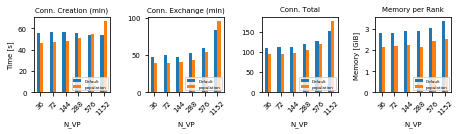

In [101]:
population['Case'] = ['population'] * len(population)

hpc_pop_cases = pd.concat([hpc_t6_s20, population])

hpc_pop_cases_p = plot_compare(hpc_pop_cases, 'benchmark_figures/hpc_vs_pop.pdf')
save_table_latex(hpc_pop_cases_p.to_latex(), 'latex_tables/hpc_vs_pop_table.txt')

hpc_pop_cases_p

#### time per connection

Conn. Creation Time \n per Conn. (min)             \
Case                                Default population   
N_VP                                                     
36                                 0.795378   0.658800   
72                                 0.798649   0.671616   
144                                0.806755   0.689904   
288                                0.783148   0.726336   
576                                0.767505   0.787824   
1152                               0.766510   0.961632   

     Conn. Exchange Time \n per Conn. (min)            Memory per connection  \
Case                                Default population               Default   
N_VP                                                                           
36                                 0.679050   0.565200              0.041246   
72                                 0.711474   0.576000              0.041283   
144                                0.678197   0.582480              0.042530   
288                                0.745036   0.631008              0.042604   
576                                0.849987   0.784224              0.044457   
1152                               1.184179   1.380960              0.049613   

                Total Conn. Time per Conn.             
Case population                    Default population  
N_VP                                                   
36     0.031489                   1.575539   1.350864  
72     0.031696                   1.607252   1.379376  
144    0.033084                   1.580944   1.418832  
288    0.031590                   1.699831   1.492848  
576    0.035842                   1.801084   1.708704  
1152   0.036685                   2.146085   2.547648

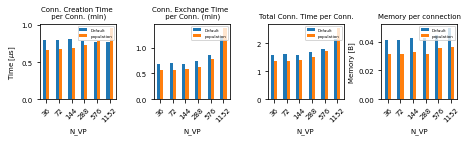

In [102]:
hpc_pop_tpc = time_and_memory_per_connection(hpc_pop_cases)
values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']

hpc_pop_tpc['Conn. Creation Time \n per Conn. (min)'] = hpc_pop_tpc['Conn. Creation Time per Conn. (min)']
hpc_pop_tpc['Conn. Exchange Time \n per Conn. (min)'] = hpc_pop_tpc['Conn. Exchange Time per Conn. (min)']

hpc_pop_tpc_p = plot_compare(hpc_pop_tpc, 'benchmark_figures/hpc_vs_pop_cases_time_per_conn.pdf',
                             values, legend_loc='upper right')
save_table_latex(hpc_pop_tpc_p.to_latex(),
                 'latex_tables/hpc_vs_pop_cases_time_per_conn_table.txt')

hpc_pop_tpc_p

## Different `Connect` rules
Compare different connection rules, `SCALE = 5 * NUMBER_OF_NODES`

**Compare *all* rules:**

Conn. Creation Time \n per Conn. (min)                                 \
Case                             all to all fixed indegree fixed outdegree   
N_VP                                                                         
36                                 0.426577       0.493706        2.449243   
72                                 0.429470       0.470713        4.443942   
144                                0.439446       0.492045        6.646988   
288                                0.438746       0.483797       12.543178   
576                                0.430217       0.491192       23.451537   
1152                               0.426487       0.497449       46.705652   

                                            \
Case fixed total number pairwise bernoulli   
N_VP                                         
36           403.516484           0.558054   
72          1432.044199           0.567144   
144         5428.919668           0.703658   
288        21576.033287           0.958210   
576        86999.583622           1.537259   
1152      349006.817077           2.669282   

     Conn. Exchange Time \n per Conn. (min)                                 \
Case                             all to all fixed indegree fixed outdegree   
N_VP                                                                         
36                                 0.335574       0.370280        0.295281   
72                                 0.364054       0.362065        1.077471   
144                                0.395359       0.350689        1.170119   
288                                0.340614       0.371167        1.214875   
576                                0.331374       0.398471        1.344749   
1152                               0.304532       0.448813        1.567061   

                                           Memory per connection  \
Case fixed total number pairwise bernoulli            all to all   
N_VP                                                               
36             9.890110           0.357815              0.028443   
72            21.878453           0.328227              0.024926   
144           27.922438           0.334764              0.022213   
288           37.947295           0.374865              0.021882   
576           67.952811           0.391354              0.021718   
1152          57.979868           0.425208              0.021776   

                                                                           \
Case fixed indegree fixed outdegree fixed total number pairwise bernoulli   
N_VP                                                                        
36         0.022084        0.022371           2.898242           0.021747   
72         0.020869        0.025641           2.341436           0.020892   
144        0.021666        0.030695           1.311867           0.021648   
288        0.023136        0.030482           1.236466           0.023179   
576        0.026963        0.033339           0.988786           0.027106   
1152       0.026589        0.033092           1.426577           0.026630   

     Total Conn. Time per Conn.                                 \
Case                 all to all fixed indegree fixed outdegree   
N_VP                                                             
36                     0.762152       0.863986        2.744524   
72                     0.796367       0.833063        5.521623   
144                    0.834806       0.843018        7.817317   
288                    0.779360       0.855248       13.758262   
576                    0.761947       0.889947       24.796495   
1152                   0.731196       0.946547       48.272922   

                                            
Case fixed total number pairwise bernoulli  
N_VP                                        
36           413.406593           0.915869  
72          1455.911602           0.895371  
144         5456.842105           1.038706  
288        2

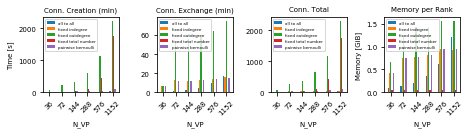

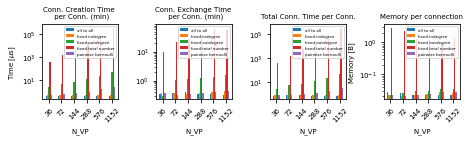

In [103]:
hpc_in = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_in.csv')
hpc_in['Case'] = ['fixed indegree']*len(hpc_in)

hpc_out = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_out.csv')
hpc_out['Case'] = ['fixed outdegree']*len(hpc_out)

hpc_all = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_all.csv')
hpc_all['Case'] = ['all to all']*len(hpc_all)

hpc_tot = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_tot.csv')
hpc_tot['Case'] = ['fixed total number']*len(hpc_tot)

hpc_bern = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_t6_bern.csv')
hpc_bern['Case'] = ['pairwise bernoulli']*len(hpc_bern)

hpc_rules = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_tot, hpc_out])

hpc_rules = calculate_T_conn_and_memory(hpc_rules)
hpc_rules = time_and_memory_per_connection(hpc_rules)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']
hpc_rules['Conn. Creation Time \n per Conn. (min)'] = hpc_rules['Conn. Creation Time per Conn. (min)']
hpc_rules['Conn. Exchange Time \n per Conn. (min)'] = hpc_rules['Conn. Exchange Time per Conn. (min)']

hpc_rules_p = plot_compare(hpc_rules, 'benchmark_figures/hpc_rules_all.pdf', legend_loc='upper left')
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_all_table.txt')
hpc_rules_p = plot_compare(hpc_rules, 'benchmark_figures/hpc_rules_all_time_per_connection.pdf',
                           values, legend_loc='upper right', logy=True)
save_table_latex(hpc_rules_p.to_latex(), 'latex_tables/hpc_rules_all_time_per_connection_table.txt')

hpc_rules_p

**Not including `fixed total number`:**

Conn. Creation Time \n per Conn. (min)                                 \
Case                             all to all fixed indegree fixed outdegree   
N_VP                                                                         
36                                 0.426577       0.493706        2.449243   
72                                 0.429470       0.470713        4.443942   
144                                0.439446       0.492045        6.646988   
288                                0.438746       0.483797       12.543178   
576                                0.430217       0.491192       23.451537   
1152                               0.426487       0.497449       46.705652   

                        Conn. Exchange Time \n per Conn. (min)                 \
Case pairwise bernoulli                             all to all fixed indegree   
N_VP                                                                            
36             0.558054                               0.335574       0.370280   
72             0.567144                               0.364054       0.362065   
144            0.703658                               0.395359       0.350689   
288            0.958210                               0.340614       0.371167   
576            1.537259                               0.331374       0.398471   
1152           2.669282                               0.304532       0.448813   

                                        Memory per connection                 \
Case fixed outdegree pairwise bernoulli            all to all fixed indegree   
N_VP                                                                           
36          0.295281           0.357815              0.028443       0.022084   
72          1.077471           0.328227              0.024926       0.020869   
144         1.170119           0.334764              0.022213       0.021666   
288         1.214875           0.374865              0.021882       0.023136   
576         1.344749           0.391354              0.021718       0.026963   
1152        1.567061           0.425208              0.021776       0.026589   

                                        Total Conn. Time per Conn.  \
Case fixed outdegree pairwise bernoulli                 all to all   
N_VP                                                                 
36          0.022371           0.021747                   0.762152   
72          0.025641           0.020892                   0.796367   
144         0.030695           0.021648                   0.834806   
288         0.030482           0.023179                   0.779360   
576         0.033339           0.027106                   0.761947   
1152        0.033092           0.026630                   0.731196   

                                                        
Case fixed indegree fixed outdegree pairwise bernoulli  
N_VP                                                    
36         0.863986        2.744524           0.915869  
72         0.833063        5.521623           0.895371  
144        0.843018        7.817317           1.038706  
288        0.855248       13.758262           1.333359  
576        0.889947       24.796495           1.928613  
1152       0.946547       48.272922           3.094774

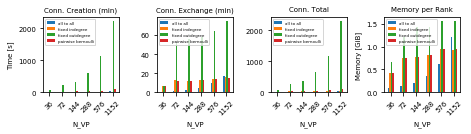

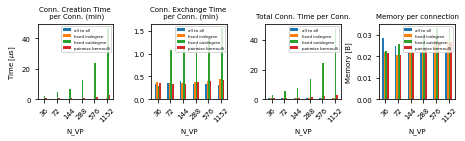

In [104]:
hpc_rules_no_tot = pd.concat([hpc_in, hpc_bern, hpc_all, hpc_out])

hpc_rules_no_tot = calculate_T_conn_and_memory(hpc_rules_no_tot)
hpc_rules_no_tot = time_and_memory_per_connection(hpc_rules_no_tot)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']
hpc_rules_no_tot['Conn. Creation Time \n per Conn. (min)'] = hpc_rules_no_tot['Conn. Creation Time per Conn. (min)']
hpc_rules_no_tot['Conn. Exchange Time \n per Conn. (min)'] = hpc_rules_no_tot['Conn. Exchange Time per Conn. (min)']

hpc_rules_no_tot_p = plot_compare(hpc_rules_no_tot, 'benchmark_figures/hpc_rules_no_tot.pdf',
                               legend_loc='upper left')
save_table_latex(hpc_rules_no_tot_p.to_latex(), 'latex_tables/hpc_rules_no_tot_table.txt')
hpc_rules_no_tot_p = plot_compare(hpc_rules_no_tot, 'benchmark_figures/hpc_rules_not_tot_time_per_connection.pdf',
                               values, legend_loc='upper right')
save_table_latex(hpc_rules_no_tot_p.to_latex(), 'latex_tables/hpc_rules_no_tot_time_per_connection_table.txt')

hpc_rules_no_tot_p

Conn. Creation Time \n per Conn. (min)                                 \
Case                             all to all fixed indegree fixed outdegree   
N_VP                                                                         
36                                 0.426577       0.493706        2.449243   
72                                 0.429470       0.470713        4.443942   
144                                0.439446       0.492045        6.646988   
288                                0.438746       0.483797       12.543178   
576                                0.430217       0.491192       23.451537   
1152                               0.426487       0.497449       46.705652   

                        Conn. Exchange Time \n per Conn. (min)                 \
Case pairwise bernoulli                             all to all fixed indegree   
N_VP                                                                            
36             0.558054                               0.335574       0.370280   
72             0.567144                               0.364054       0.362065   
144            0.703658                               0.395359       0.350689   
288            0.958210                               0.340614       0.371167   
576            1.537259                               0.331374       0.398471   
1152           2.669282                               0.304532       0.448813   

                                        Memory per connection                 \
Case fixed outdegree pairwise bernoulli            all to all fixed indegree   
N_VP                                                                           
36          0.295281           0.357815              0.028443       0.022084   
72          1.077471           0.328227              0.024926       0.020869   
144         1.170119           0.334764              0.022213       0.021666   
288         1.214875           0.374865              0.021882       0.023136   
576         1.344749           0.391354              0.021718       0.026963   
1152        1.567061           0.425208              0.021776       0.026589   

                                        Total Conn. Time per Conn.  \
Case fixed outdegree pairwise bernoulli                 all to all   
N_VP                                                                 
36          0.022371           0.021747                   0.762152   
72          0.025641           0.020892                   0.796367   
144         0.030695           0.021648                   0.834806   
288         0.030482           0.023179                   0.779360   
576         0.033339           0.027106                   0.761947   
1152        0.033092           0.026630                   0.731196   

                                                        
Case fixed indegree fixed outdegree pairwise bernoulli  
N_VP                                                    
36         0.863986        2.744524           0.915869  
72         0.833063        5.521623           0.895371  
144        0.843018        7.817317           1.038706  
288        0.855248       13.758262           1.333359  
576        0.889947       24.796495           1.928613  
1152       0.946547       48.272922           3.094774

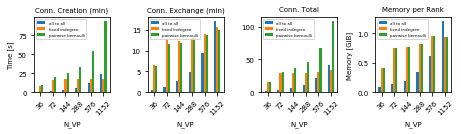

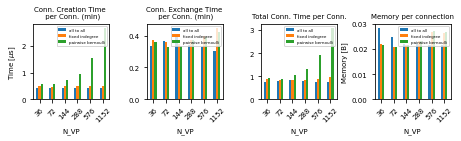

In [105]:
hpc_rules_no_fo = pd.concat([hpc_in, hpc_bern, hpc_all])

hpc_rules_no_fo = calculate_T_conn_and_memory(hpc_rules_no_fo)
hpc_rules_no_fo = time_and_memory_per_connection(hpc_rules_no_fo)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']
hpc_rules_no_fo['Conn. Creation Time \n per Conn. (min)'] = hpc_rules_no_fo['Conn. Creation Time per Conn. (min)']
hpc_rules_no_fo['Conn. Exchange Time \n per Conn. (min)'] = hpc_rules_no_fo['Conn. Exchange Time per Conn. (min)']

hpc_rules_no_fo_p = plot_compare(hpc_rules_no_fo, 'benchmark_figures/hpc_rules_no_out.pdf',
                                 legend_loc='upper left')
save_table_latex(hpc_rules_no_fo_p.to_latex(), 'latex_tables/hpc_rules_no_out_table.txt')
hpc_rules_no_fo_p = plot_compare(hpc_rules_no_fo, 'benchmark_figures/hpc_rules_not_out_time_per_connection.pdf',
                                 values, legend_loc='upper right')
save_table_latex(hpc_rules_no_fo_p.to_latex(), 'latex_tables/hpc_rules_no_out_time_per_connection_table.txt')

hpc_rules_no_tot_p

## Multi-Area Model

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,120.426247,36.050572,156.477170,2.551239,0.071292,1.526557e-16
72,157.620768,36.592974,194.214109,2.552825,0.061337,3.987630e-03
144,244.647294,39.647938,284.296193,2.553713,0.173153,7.202148e-03
288,409.156298,43.565511,452.722374,2.626425,0.255225,1.665335e-16
576,730.886775,35.718095,766.605952,2.677611,0.105154,-5.551115e-17
1152,1437.297899,62.590330,1499.890033,2.940089,0.448385,-5.551115e-17


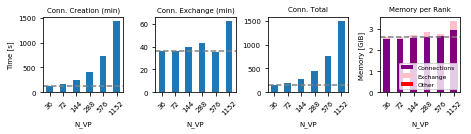

In [106]:
MAM_t6_s0_0625 = pd.read_csv('benchmark_results/MAM_8adec3cd_daint_t6.csv')

MAM_t6_s0_0625['T_conns_min'] = MAM_t6_s0_0625['T_network_global_min'] + MAM_t6_s0_0625['T_connect_min']
MAM_t6_s0_0625['T_conns_max'] = MAM_t6_s0_0625['T_network_global_max'] + MAM_t6_s0_0625['T_connect_max']

MAM_t6_s0_0625 = calculate_T_conn_and_memory(MAM_t6_s0_0625)
MAM_t6_s0_0625_p = plot_results(MAM_t6_s0_0625, 'benchmark_figures/multi-area-model.pdf', plot_T_sim=False)

save_table_latex(MAM_t6_s0_0625_p.to_latex(), 'latex_tables/multi-area-model_table.txt')

MAM_t6_s0_0625_p

## 4x4 mesocircuit

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
N_VP,,,,,,
36,171.05,6.04,177.09,0.500407,0.118544,0.051779
72,194.96,6.58,201.55,0.519694,0.103678,0.066061
144,227.96,8.07,236.04,0.538167,0.124051,0.077799
288,333.89,8.96,342.87,0.453717,0.176499,0.105154
576,521.29,10.29,531.64,0.407574,0.230692,0.173216
1152,964.58,13.71,978.42,0.408856,0.366698,0.305754


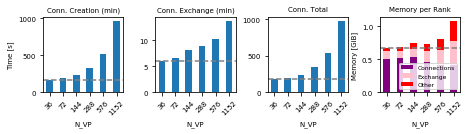

In [107]:
meso_t6_s0_0625 = pd.read_csv('benchmark_results/4x4_mesocircuit_8adec4cd_daint_t6.csv')

meso_t6_s0_0625 = calculate_T_conn_and_memory(meso_t6_s0_0625)
meso_t6_s0_0625_p = plot_results(meso_t6_s0_0625, 'benchmark_figures/mesocircuit.pdf', plot_T_sim=False)

save_table_latex(meso_t6_s0_0625_p.to_latex(), 'latex_tables/mesocircuit_table.txt')

meso_t6_s0_0625_p

## Comapare hpc, population, MAM and 4x4

Conn. Creation Time \n per Conn. (min)                                  \
Case                                    4x4        MAM       hpc population   
N_VP                                                                          
36                                17.825790   2.874098  0.795378   0.658800   
72                                20.316339   3.761778  0.798649   0.671616   
144                               23.753340   5.838750  0.806755   0.689904   
288                               34.791047   9.764916  0.783148   0.726336   
576                               54.317855  17.443326  0.767505   0.787824   
1152                             100.507309  34.302514  0.766510   0.961632   

     Conn. Exchange Time \n per Conn. (min)                                 \
Case                                    4x4       MAM       hpc population   
N_VP                                                                         
36                                 0.629452  0.860384  0.679050   0.565200   
72                                 0.685687  0.873328  0.711474   0.576000   
144                                0.840891  0.946237  0.678197   0.582480   
288                                0.933624  1.039734  0.745036   0.631008   
576                                1.072207  0.852447  0.849987   0.784224   
1152                               1.428555  1.493779  1.184179   1.380960   

     Memory per connection                                 \
Case                   4x4       MAM       hpc population   
N_VP                                                        
36                0.067637  0.065630  0.041246   0.031489   
72                0.068116  0.065420  0.041283   0.031696   
144               0.072355  0.068241  0.042530   0.033084   
288               0.068858  0.072114  0.042604   0.031590   
576               0.069737  0.069639  0.044457   0.035842   
1152              0.084737  0.084798  0.049613   0.036685   

     Total Conn. Time per Conn.                                  
Case                        4x4        MAM       hpc population  
N_VP                                                             
36                    18.455242   3.734491  1.575539   1.350864  
72                    21.003068   4.635115  1.607252   1.379376  
144                   24.595272   6.785010  1.580944   1.418832  
288                   35.726755  10.804663  1.699831   1.492848  
576                   55.396314  18.295799  1.801084   1.708704  
1152                 101.949410  35.796336  2.146085   2.547648

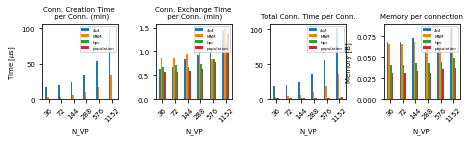

In [108]:
hpc_t6_s20['Case']      = ['hpc']*len(hpc_t6_s20)
MAM_t6_s0_0625['Case']  = ['MAM']*len(MAM_t6_s0_0625)
meso_t6_s0_0625['Case'] = ['4x4']*len(meso_t6_s0_0625)
population['Case']      = ['population']*len(population)

hpc_pop_MAM_4x4 = pd.concat([hpc_t6_s20, population, MAM_t6_s0_0625, meso_t6_s0_0625])

hpc_pop_MAM_4x4 = time_and_memory_per_connection(hpc_pop_MAM_4x4)

values = ['Conn. Creation Time \n per Conn. (min)',
          'Conn. Exchange Time \n per Conn. (min)',
          'Total Conn. Time per Conn.',
          'Memory per connection']
hpc_pop_MAM_4x4['Conn. Creation Time \n per Conn. (min)'] = hpc_pop_MAM_4x4['Conn. Creation Time per Conn. (min)']
hpc_pop_MAM_4x4['Conn. Exchange Time \n per Conn. (min)'] = hpc_pop_MAM_4x4['Conn. Exchange Time per Conn. (min)']


hpc_pop_MAM_4x4_p = plot_compare(hpc_pop_MAM_4x4, 'benchmark_figures/hpc_population_MAM_4x4.pdf',
                                 values=values, legend_loc='upper right')
save_table_latex(hpc_pop_MAM_4x4_p.to_latex(), 'latex_tables/hpc_population_MAM_4x4_table.txt')

hpc_pop_MAM_4x4_p

## Fixed VP, different threads.

,Conn. Creation (min),Conn. Exchange (min),Conn. Total,connections,ini,other
Threads,,,,,,
1,17.40,11.70,29.40,1.915039,0.795025,0.386829
3,31.06,24.88,59.71,1.930013,0.293794,0.089876
6,41.26,34.54,81.53,1.995850,0.075687,0.047707
9,43.63,45.66,89.95,1.974826,0.076844,0.038896
18,57.58,71.10,130.47,1.953695,0.014393,0.040708
36,73.43,77.09,150.52,1.943454,0.020833,0.035204


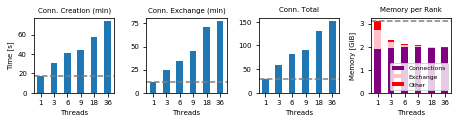

In [109]:
hpc_threads_n1 = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_s15_threads.csv')

hpc_threads_n1 = calculate_T_conn_and_memory(hpc_threads_n1)

hpc_threads_n1['Threads'] = hpc_threads_n1['THREADS_PER_TASK']

hpc_threads_n1_p = plot_results(hpc_threads_n1, 'benchmark_figures/hpc_fixedVP_diff_threads_n1.pdf',
                                index='Threads', rot=0)

save_table_latex(hpc_threads_n1_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_n1_table.txt')
hpc_threads_n1_p

Conn. Creation (min)                         Conn. Exchange (min)  \
Case                    2.14    2.16   2.18 8adec3cd                 2.14   
Threads                                                                     
1                      36.44   21.73  17.62    17.40                 0.62   
3                      47.89   38.73  30.85    31.06                 0.89   
6                      52.17   51.38  42.25    41.26                 0.96   
9                      53.47   58.84  43.85    43.63                 0.91   
18                     54.55   81.97  56.37    57.58                 1.38   
36                     61.78  124.92  74.22    73.43                 1.44   

                               Conn. Total                           \
Case      2.16   2.18 8adec3cd        2.14    2.16    2.18 8adec3cd   
Threads                                                               
1        18.79  11.87    11.70       38.13   41.59   29.74    29.40   
3        29.74  24.27    24.88       53.94   74.21   61.06    59.71   
6        35.99  32.64    34.54       55.97   89.20   78.62    81.53   
9        50.30  48.41    45.66       56.75  110.85   93.32    89.95   
18       66.25  68.98    71.10       58.47  151.96  127.35   130.47   
36       91.19  77.44    77.09       63.22  216.11  151.66   150.52   

        Memory per Rank                                
Case               2.14      2.16      2.18  8adec3cd  
Threads                                                
1              2.312773  5.072531  3.096897  3.096893  
3              2.028328  4.422857  2.269574  2.313683  
6              1.983972  4.332034  2.121685  2.119244  
9              1.973401  4.311907  2.100494  2.090566  
18             1.963256  4.293865  2.008091  2.008796  
36             1.968212  4.284930  1.989075  1.999492

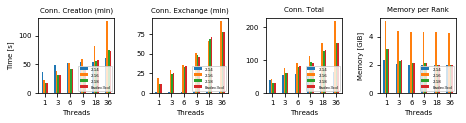

In [110]:
hpc_threads_214 = pd.read_csv('benchmark_results/hpc_benchmark_214_daint_threads_SCALE15.csv')
hpc_threads_214['Case'] = ['2.14']*len(hpc_threads_214)
hpc_threads_216 = pd.read_csv('benchmark_results/hpc_benchmark_216_daint_threads_SCALE15.csv')
hpc_threads_216['Case'] = ['2.16']*len(hpc_threads_216)
hpc_threads_218 = pd.read_csv('benchmark_results/hpc_benchmark_218_daint_threads_SCALE15.csv')
hpc_threads_218['Case'] = ['2.18']*len(hpc_threads_218)
hpc_threads_m   = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_s15_threads.csv')
hpc_threads_m['Case']   = ['8adec3cd']*len(hpc_threads_m)

hpc_threads = pd.concat([hpc_threads_214, hpc_threads_216, hpc_threads_218, hpc_threads_m])

hpc_threads = calculate_T_conn_and_memory(hpc_threads)
hpc_threads['Threads'] = hpc_threads['THREADS_PER_TASK']
hpc_threads_p = plot_compare(hpc_threads, 'benchmark_figures/hpc_fixedVP_diff_threads_comparison.pdf',
                             index='Threads', rot=0)
save_table_latex(hpc_threads_p.to_latex(), 'latex_tables/hpc_fixedVP_diff_threads_comparison.txt')

hpc_threads_p

Conn. Total                        Memory per Rank                      \
Case        2.14   2.16   2.18 8adec3cd            2.14      2.16      2.18   
N_VP                                                                          
36         37.39  41.12  29.69    29.57        2.312611  5.072531  3.096897   
72         39.99  42.98  29.81    29.34        2.327074  5.073708  3.107514   
144        42.03  45.60  30.39    30.19        2.707514  5.075892  3.109698   
288        44.44  46.59  31.11    31.17        3.149024  5.080248  3.114054   
576        46.74  48.86  33.61    34.08        3.144015  5.108859  3.578192   
1152       49.62  55.41  39.56    40.25        3.161597  5.123802  4.092529   

               Simulation                           
Case  8adec3cd       2.14    2.16    2.18 8adec3cd  
N_VP                                                
36    3.096893      82.85   88.38   90.13    89.62  
72    3.107514      84.19   87.63   90.85    90.32  
144   3.109698      87.78   92.08   95.31    94.96  
288   3.114054      97.88  105.33  105.49   106.58  
576   3.577714     110.44  119.03  128.16   128.64  
1152  4.092366     140.54  163.31  172.90   173.25

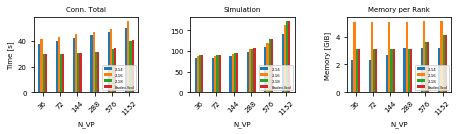

In [111]:
hpc_214 = pd.read_csv('benchmark_results/hpc_benchmark_214_daint_n1_SCALE15.csv')
hpc_214['Case'] = ['2.14']*len(hpc_214)
hpc_216 = pd.read_csv('benchmark_results/hpc_benchmark_216_daint_n1_SCALE15.csv')
hpc_216['Case'] = ['2.16']*len(hpc_216)
hpc_218 = pd.read_csv('benchmark_results/hpc_benchmark_218_daint_n1_SCALE15.csv')
hpc_218['Case'] = ['2.18']*len(hpc_218)
hpc_m   = pd.read_csv('benchmark_results/hpc_benchmark_8adec3cd_daint_n1_s15.csv')
hpc_m['Case']   = ['8adec3cd']*len(hpc_m)

hpc_versions = pd.concat([hpc_214, hpc_216, hpc_218, hpc_m])

hpc_versions = calculate_T_conn_and_memory(hpc_versions)
hpc_versions['num. nodes'] = hpc_versions['NUMBER_OF_NODES']
hpc_versions['Simulation'] = hpc_versions['T_sim']
hpc_versions_p = plot_compare(hpc_versions, 'benchmark_figures/hpc_different_versions.pdf',
                              values = ['Conn. Total', 'Simulation', 'Memory per Rank'],
                              rot=45)
save_table_latex(hpc_versions_p.to_latex(), 'latex_tables/hpc_different_versions.txt')

hpc_versions_p